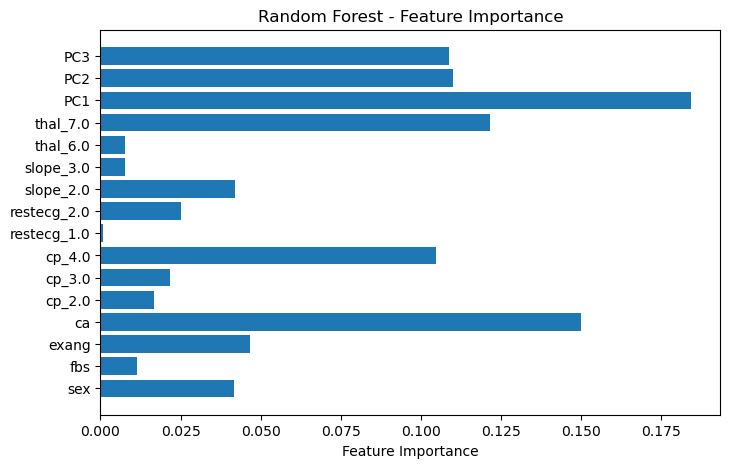

In [2]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

model = RandomForestClassifier()
df=pd.read_csv("../data/pca_heart.csv")
y=df['target']
X=df.drop('target', axis=1)
model.fit(X, y)
# Plot
importances = model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feat_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.show()

In [5]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=5)  
rfe.fit(X, y)

selected = X.columns[rfe.support_]
print("Selected Features:", list(selected))

Selected Features: ['sex', 'ca', 'cp_4.0', 'thal_7.0', 'PC1']


In [7]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler


encoded_features = df.drop(columns=['target', 'PC1', 'PC2', 'PC3'])



y = df['target']


selector = SelectKBest(score_func=chi2, k=5)  
X_new = selector.fit_transform(encoded_features, y)


selected = selector.get_support()
selected_features = encoded_features.columns[selected]
print("Top features by Chi²:", selected_features.tolist())

Top features by Chi²: ['exang', 'ca', 'cp_3.0', 'cp_4.0', 'thal_7.0']
